- We want to create a SVR that predicts the right value of a target  
- we also show the predictions for each diagnosis

In [19]:
import pandas as pd
import numpy as np 
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv("df.csv", index_col=0)
df.head()

,column_3,target,column_11,column_16,column_22,column_10,column_26,column_19,column_13,column_12,...,column_7,column_5,column_21,column_29,column_15,column_9,column_6,column_24,column_17,column_18
0,18,0.0,3.5,31.0,126.0,24.18,5157.0,100.0000,35.00,24.00,...,1.116260,0,21.0,14617.0,17.0,251.7,1,1.5,2.0,7.0
1,10,5.0,1.0,37.0,240.0,13.30,6451.0,12.5000,22.00,15.00,...,NaN,0,30.0,18691.0,26.0,159.7,0,1.5,4.0,1.0
2,16,15.0,1.5,40.0,83.0,34.04,6832.0,50.0000,NaN,5.67,...,1.280900,0,44.0,24193.0,30.0,334.1,0,1.5,6.0,6.0
3,12,1.0,4.0,21.0,144.0,27.37,5266.0,100.0000,35.33,23.33,...,0.937913,0,24.0,15759.0,25.0,287.7,1,1.5,2.0,5.0
4,9,12.0,0.0,32.0,66.0,19.88,7331.0,-28.5714,12.33,8.33,...,1.360140,0,47.0,16014.0,30.0,203.7,1,1.5,3.0,-2.0


In [3]:
df.shape

(1403, 32)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1403 entries, 0 to 1402
Data columns (total 32 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   column_3   1403 non-null   int64  
 1   target     1396 non-null   float64
 2   column_11  1392 non-null   float64
 3   column_16  1391 non-null   float64
 4   column_22  1361 non-null   float64
 5   column_10  1403 non-null   float64
 6   column_26  1150 non-null   float64
 7   column_19  1380 non-null   float64
 8   column_13  1385 non-null   float64
 9   column_12  1399 non-null   float64
 10  column_14  1401 non-null   float64
 11  DX         1403 non-null   int64  
 12  column_8   1403 non-null   float64
 13  column_31  1341 non-null   float64
 14  column_27  1296 non-null   float64
 15  column_25  1261 non-null   float64
 16  column_1   1403 non-null   float64
 17  column_4   1403 non-null   int64  
 18  column_2   1403 non-null   int64  
 19  column_28  1082 non-null   float64
 20  column_23  13

In [5]:
df.isna().any() # I have to delete all rows without target

column_3     False
target        True
column_11     True
column_16     True
column_22     True
column_10    False
column_26     True
column_19     True
column_13     True
column_12     True
column_14     True
DX           False
column_8     False
column_31     True
column_27     True
column_25     True
column_1     False
column_4     False
column_2     False
column_28     True
column_23     True
column_30     True
column_7      True
column_5     False
column_21     True
column_29     True
column_15     True
column_9     False
column_6     False
column_24     True
column_17     True
column_18     True
dtype: bool

In [6]:
df = df.dropna(subset="target")
df.shape

(1396, 32)

In [7]:
df["target"].isna().sum() #now we can proceed

0

In [8]:
def plot_means(df, target_column, dx_column, colors) -> None:
    """
    Creates a bar plot of means for a specific column in a DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame from which to extract the data.
    target_column (str): The name of the target column in the DataFrame.
    dx_column (str): The name of the column to group by.
    colors (dict): A dictionary mapping group values to colors.

    Example:
    >>> df = pd.DataFrame({'target': [100, 200, 200, 60, 100, 200, 50, 0, 100, 100], 'DX': [0, 1, 2, 0, 1, 2, 0, 0, 1, 1]})
    >>> colors = {0:'green', 1:'orange', 2:'red'}
    >>> plot_means(df, 'target', 'DX', colors)
    """

    # Calculate the means
    mean_values = df.groupby(dx_column)[target_column].mean()

    # Create a bar plot with different colors for each bar
    plt.bar(mean_values.index, mean_values.values, color=[colors[i] for i in mean_values.index])

    # Add the numbers above each column
    for i in mean_values.index:
        plt.text(i, mean_values[i], str(round(mean_values[i], 2)), ha='center', va='bottom')

    # Set the x-axis limits
    plt.xticks(mean_values.index)
    plt.xlabel(dx_column)
    plt.ylabel(f"{target_column} mean")
    plt.title(f"{target_column} distribution for {dx_column}")

    # Show the plot
    plt.show()



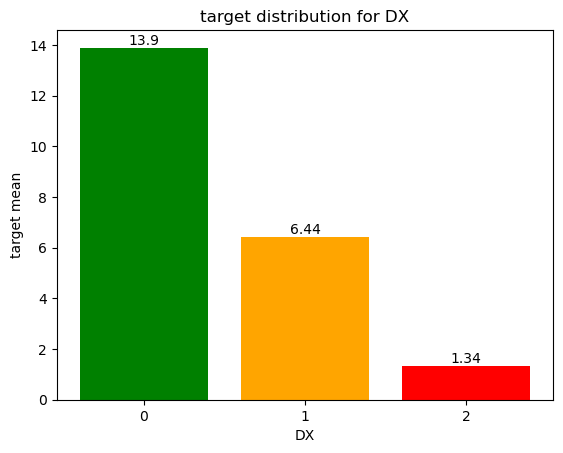

In [9]:
plot_means(df, "target", "DX", colors = {0:'green', 1:'orange', 2:'red'})

## preprocessing with pipeline

In [10]:
#pipeline definition
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # data imputation
    ('scaler', StandardScaler()),  # standardization
])

#train test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=42)

# pipeline fitting
pipeline.fit(X_train_raw)

# data transformation
X_train = pd.DataFrame(pipeline.transform(X_train_raw))
X_test = pd.DataFrame(pipeline.transform(X_test_raw))

In [11]:
def plot_feature_importances(X_train, y_train, n_estimators=35) -> pd.DataFrame:
    """
    Trains a RandomForestRegressor and plots the feature importances.

    Parameters:
    X_train (pd.DataFrame): The input features for training.
    y_train (pd.Series): The target output for training.
    n_estimators (int, optional): The number of trees in the forest. Defaults to 35.

    Returns:
    final_df (pd.DataFrame): A DataFrame containing the features and their corresponding importances.
    """
    # Train the model
    model = RandomForestRegressor(n_estimators=n_estimators)
    model.fit(X_train, y_train)

    # Get feature importances
    importances = model.feature_importances_

    # Create a DataFrame with feature names and their corresponding importances
    final_df = pd.DataFrame({'Features': X_train.columns, 'Importances': importances})

    # Set "Features" as index
    final_df.set_index("Features", inplace=True)

    # Sort the DataFrame by "Importances"
    final_df = final_df.sort_values("Importances")

    # Plot the DataFrame
    final_df.plot.bar(color = "teal")
    plt.show()

    # Return the DataFrame
    return final_df


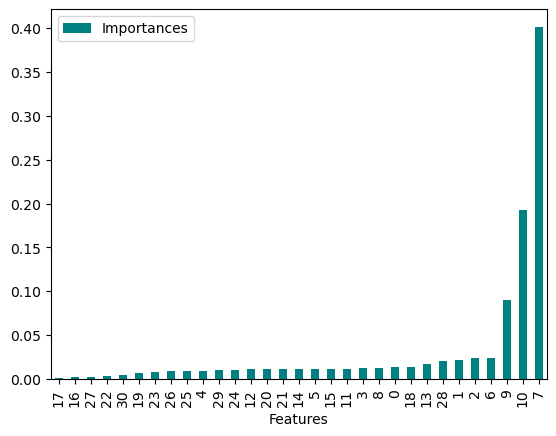

          Importances
Features             
17           0.000875
16           0.001877
27           0.002222
22           0.002954
30           0.004758
19           0.006776
23           0.008304
26           0.009257
25           0.009367
4            0.009499
29           0.009780
24           0.010753
12           0.011053
20           0.011272
21           0.011380
14           0.011444
5            0.011609
15           0.011713
11           0.011723
3            0.011982
8            0.012457
0            0.013246
18           0.013614
13           0.017356
28           0.020245
1            0.022157
2            0.024361
6            0.024401
9            0.089772
10           0.192302
7            0.401490


In [12]:
importances_df = plot_feature_importances(X_train, y_train)
print(importances_df)

In [13]:
#VIF
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif.round(1)

,VIF Factor,features
0,1.2,0
1,6.4,1
2,3.9,2
3,2.0,3
4,36.7,4
5,2.8,5
6,6.8,6
7,15.6,7
8,10.5,8
9,5.9,9


In [14]:
#remove all features with VIF>10
to_drop_vif = vif[vif["VIF Factor"] > 10]
# Get the indices of the features to drop
to_drop_indices = to_drop_vif["features"].values

# Drop the features from X_train and X_test
X_train = np.delete(X_train, to_drop_indices, axis=1)
X_test = np.delete(X_test, to_drop_indices, axis=1)

In [15]:
#best hyperparameters
param_grid = {'C': [10,100,1000 ], 'kernel': ['poly','rbf','linear']}

svr = SVR()
grid = GridSearchCV(svr, param_grid, cv=5)

# training
grid.fit(X_train, y_train)

print(grid.best_params_)



{'C': 10, 'kernel': 'rbf'}


In [16]:
# SVR with best Hyperparameters
best_svr = SVR(**grid.best_params_)

# fitting on train set
best_svr.fit(X_train, y_train)

# prediction on test set
y_pred = best_svr.predict(X_test)

In [17]:
#Regression report
def regression_report(y_test, y_pred) -> None:
    """
    Prints the regression metrics RMSE, MAE, and R^2 score.

    Parameters:
    y_test (pd.Series or np.array): The actual target values for the test set.
    y_pred (pd.Series or np.array): The predicted target values for the test set.

    Prints:
    A table with the following regression metrics: RMSE, MAE, and R^2 score.
    """
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{'Metric':<18}{'Score':<10}")
    print("-"*30)
    print(f"{'RMSE':<18}{rmse:<10.2f}")
    print(f"{'MAE':<18}{mae:<10.2f}")
    print(f"{'R^2':<18}{r2:<10.2f}")

In [20]:
regression_report(y_test, y_pred)

Metric            Score     
------------------------------
RMSE              2.89      
MAE               2.22      
R^2               0.77      


In [21]:
def plot_predictions(X_test, y_test, y_pred):
    """
    Plots the predicted values against the actual values.

    Parameters:
    X_test (pd.DataFrame): The input features for the test set.
    y_test (pd.Series or np.array): The actual target values for the test set.
    y_pred (pd.Series or np.array): The predicted target values for the test set.

    Displays:
    A scatter plot with the actual values on the x-axis and the predicted values on the y-axis. 
    The points are colored based on the 'DX' values in the test set.
    """
    from adjustText import adjust_text
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(15,7))
    y_test_list = list(y_test)
    y_pred_list = list(y_pred)
    dx_list = list(X_test_raw["DX"])
    colors = ['green','orange', 'red']   # Define colors based on 'DX' values
    markers = ['o', 's','^']   # Define markers based on 'DX' values
    dx_labels = [0, 1, 2]   # Define labels for each 'DX' value

    for idx, dx in enumerate(set(dx_list)):
        x = [y_test_list[i] for i in range(len(dx_list)) if dx_list[i] == dx]
        y = [y_pred_list[i] for i in range(len(dx_list)) if dx_list[i] == dx]
        label = dx_labels[dx]
        plt.scatter(x, y, marker=markers[idx], color=colors[idx], label=label)

    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Comparison of Actual and Predicted Values')

    # Reference line for perfect predictions
    plt.plot([0, np.max(y_test_list)], [0, np.max(y_test_list)], 'r--')

    plt.legend(loc='lower right', prop={'size': 10})

    # Add a small buffer for the x and y axes
    plt.xlim(-0.01 * np.max(y_test_list), np.max(y_test_list))
    plt.ylim(-0.01 * np.max(y_test_list), np.max(y_test_list))

    plt.show()


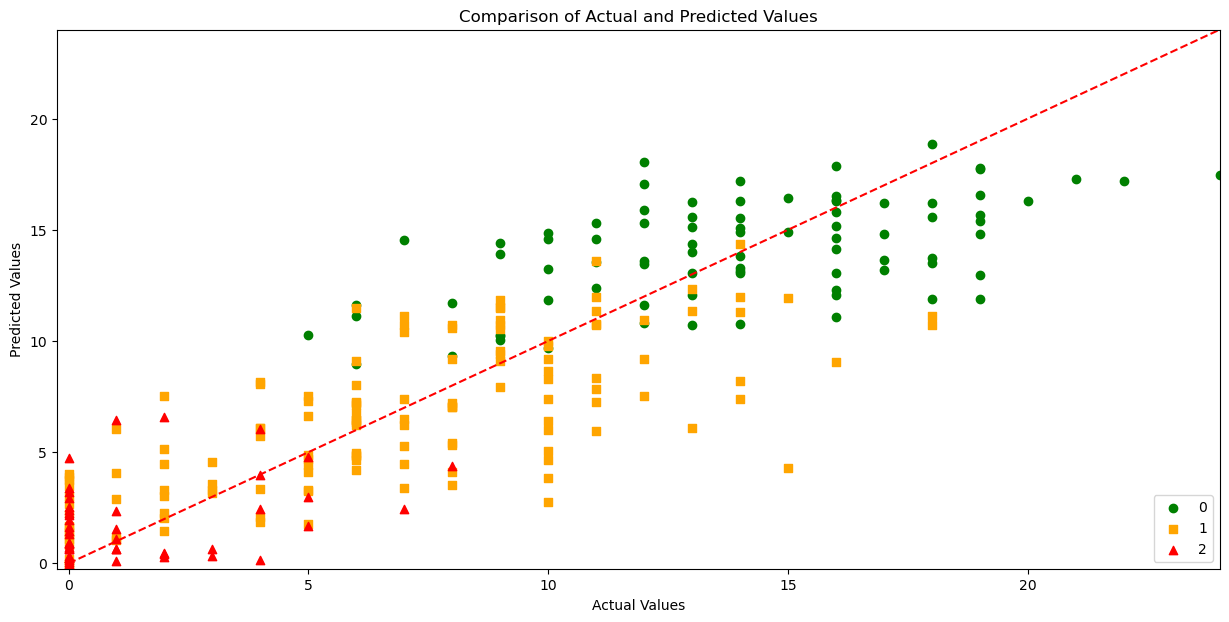

In [22]:
plot_predictions(X_test, y_test, y_pred)